In [4]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

In [15]:
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cude:{device_id}' # cuda:1 id GPU
n_epochs = 10
batch_size = 128

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    ]
)

dataset_train = datasets.MNIST('.', 
                                train=True,
                                download=True,
                                transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=2,
                                        drop_last=True,)
dataset_test = datasets.MNIST('.',
                            train=False,
                            download=True,
                            transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=2,
                                        drop_last=True,)

In [ ]:
dataset_train[0]

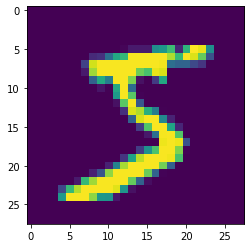

In [5]:
import matplotlib.pyplot as plt

plt.imshow(dataset_train.data[0].detach().numpy())
plt.show()

In [17]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        #custom init: nn.init.xavier_normal_(self.linear.weight)
        self.do1 = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.linear2(x)

        return x

In [18]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train()
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [13]:
# Как форм. батч
# dataloader берет из sampler набор индексов и по этим индексам получает эл-ты из Dataset

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    target = []
    for item in data:
        pics.append(numpy.array(item[0]))
        target.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() # B x W x H
    target = torch.from_numpy(numpy.array(target)).type(torch.LongTensor)

    return {
        'data': pics.view(pics.size(0), -1), # B x 7xx преобразуем матрицу 28х28 в вектор 7хх
        'target': target,
        }
        
dataloader = DataLoader(dataset_train, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True,
                        )
for epoch in range(n_epochs):
    
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.3654801845550537
epoch: 0, step: 200, loss: 0.3303302526473999
epoch: 0, step: 400, loss: 0.28192397952079773
epoch: 1, step: 0, loss: 0.3811625838279724
epoch: 1, step: 200, loss: 0.33042198419570923
epoch: 1, step: 400, loss: 0.20368735492229462
epoch: 2, step: 0, loss: 0.10563197731971741
epoch: 2, step: 200, loss: 0.15710918605327606
epoch: 2, step: 400, loss: 0.12734121084213257
epoch: 3, step: 0, loss: 0.18564029037952423
epoch: 3, step: 200, loss: 0.0924237072467804
epoch: 3, step: 400, loss: 0.10415872931480408
epoch: 4, step: 0, loss: 0.08158305287361145
epoch: 4, step: 200, loss: 0.12703637778759003
epoch: 4, step: 400, loss: 0.09750518202781677
epoch: 5, step: 0, loss: 0.13338172435760498
epoch: 5, step: 200, loss: 0.0800875797867775
epoch: 5, step: 400, loss: 0.151255264878273
epoch: 6, step: 0, loss: 0.053298622369766235
epoch: 6, step: 200, loss: 0.09417596459388733
epoch: 6, step: 400, loss: 0.1196545735001564
epoch: 7, step: 0, loss: 0.0728824

In [ ]:
# или так
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.view(inputs.size(0), -1).to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

## Conv

In [7]:
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [19]:
class ConvBNDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(input_ch, output_ch, kernel_size=kernel_size, 
                              stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(output_ch)
        self.do = nn.Dropout(dropout_p)
        self.activ= nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.do(x)

        return x

class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.convbn1 = ConvBNDO(input_ch, hidden_ch, kernel_size=5, stride=2, 
                                padding=2) # 28x28 -> 14x14
        self.convbn2 = ConvBNDO(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                                padding=1)
        self.conv = nn.Conv2d(hidden_ch, 10, kernel_size=3, stride=1, 
                                padding=1)
        self.clf = nn.Linear(10 * 14 *14, output_dim)        

    def forward(self, x):
        x = self.convbn1(x)
        x = self.convbn2(x)
        x = self.conv(x)
        x = self.clf(x.view(x.size(0), -1))

        return x

In [20]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [22]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        #if epoch == 0:
            #print(f'step {i}, size = {inputs.shape}, inputs = {inputs}')
        optim.zero_grad()

        predict = model_conv(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #test model
    for i, batch in enumerate(testloader):
        inputs, labels = batch

        model_conv.eval()
        loss_test = 0
        with torch.no_grad():
            predict = model_conv(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
    
    model_conv.train()
    # print('test loss:', loss_test / i)
    #save every epoch

    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')

step 0, size = torch.Size([128, 1, 28, 28]), inputs = tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[

KeyboardInterrupt: 

# Задание 1. ResNet18 on CIFAR10

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [05:31<00:00, 513700.84it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


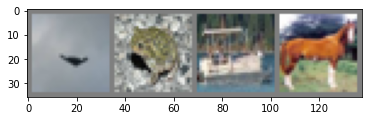

plane frog  ship  horse


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))